In [1433]:
import plotly.graph_objects as go
from IPython.display import display

def init_real_time_plot():
    # global fig_x, fig_y, fig_z
    global fig_y1, fig_y3, fig_y5, fig_y6, fig_y7

    # Initialize figures with two traces each: actual values and moving averages
    # fig_x = go.FigureWidget(data=[
    #     go.Scatter(x=[], y=[], mode='lines+markers', name='X Values'),
    #     go.Scatter(x=[], y=[], mode='lines', name='X Moving Avg', line=dict(color='red'))])
    fig_y1 = go.FigureWidget(data=[
        go.Scatter(x=[], y=[], mode='lines+markers', name='Y1 Values'),
        go.Scatter(x=[], y=[], mode='lines', name='Y1 Moving Avg', line=dict(color='red'))])
    fig_y3 = go.FigureWidget(data=[
        go.Scatter(x=[], y=[], mode='lines+markers', name='Y3 Values'),
        go.Scatter(x=[], y=[], mode='lines', name='Y3 Moving Avg', line=dict(color='red'))])
    fig_y5 = go.FigureWidget(data=[
        go.Scatter(x=[], y=[], mode='lines+markers', name='Y5 Values'),
        go.Scatter(x=[], y=[], mode='lines', name='Y5 Moving Avg', line=dict(color='red'))])
    fig_y6 = go.FigureWidget(data=[
        go.Scatter(x=[], y=[], mode='lines+markers', name='Y6 Values'),
        go.Scatter(x=[], y=[], mode='lines', name='Y6 Moving Avg', line=dict(color='red'))])
    fig_y7 = go.FigureWidget(data=[
        go.Scatter(x=[], y=[], mode='lines+markers', name='Y7 Values'),
        go.Scatter(x=[], y=[], mode='lines', name='Y7 Moving Avg', line=dict(color='red'))])

    # Set titles and display the figures
    # fig_x.update_layout(title_text='Real-Time X Values')
    fig_y1.update_layout(title_text='Real-Time Y1 Values')
    fig_y3.update_layout(title_text='Real-Time Y3 Values')
    fig_y5.update_layout(title_text='Real-Time Y5 Values')
    fig_y6.update_layout(title_text='Real-Time Y6 Values')
    fig_y7.update_layout(title_text='Real-Time Y7 Values')

    # display(fig_x, fig_y, fig_z)
    display(fig_y1, fig_y3, fig_y5, fig_y6, fig_y7)




In [2]:
def send_alert_to_microbit(serial_connection, message):
    """
    Sends an alert message to the microbit via the serial connection.

    Args:
    - serial_connection: The open serial connection to the microbit.
    - message: The message to send as a string.
    """
    serial_connection.write(message.encode())
    # serial_connection.close()

## For collecting readings only

In [782]:
import numpy as np
from collections import deque
from scipy.signal import resample
from sklearn.utils import resample as sklearn_resample

class RealTimeVariance:
    def __init__(self, window_size):
        self.window_size = window_size
        self.window = deque(maxlen=window_size)
        self.sum_x = 0
        self.sum_x2 = 0

    def update(self, new_value):
        if len(self.window) == self.window_size:
            old_value = self.window.popleft()
            self.sum_x -= old_value
            self.sum_x2 -= old_value ** 2
        
        self.window.append(new_value)
        self.sum_x += new_value
        self.sum_x2 += new_value ** 2

        if len(self.window) < self.window_size:
            return None  # Not enough values to compute variance yet
        else:
            n = len(self.window)
            mean = self.sum_x / n
            return (self.sum_x2 / n) - (mean ** 2)

# Example usage
# window_size = 20
# rt_var = RealTimeVariance(window_size)
# streaming_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        
        
def compute_variance_windows(signal, window_size):
    """
    Computes variance for sliding windows across a signal.

    :param signal: 1D numpy array of signal values.
    :param window_size: The number of samples in each window.
    :return: 1D numpy array of variances for each window.
    """
    variances = np.array([np.var(signal[i:i + window_size]) for i in range(len(signal) - window_size + 1)])
    return variances

def find_action_start_end(variances, threshold=920):
    """
    Identifies the start and end of an action based on variance changes.

    :param variances: 1D numpy array of variances for each window.
    :param threshold: Threshold for considering a variance as indicating action start/end.
    :return: Tuple (start_index, end_index) of the action.
    """
    segments = []
    in_segment = False
    for i, v in enumerate(variances):
        if v > threshold and not in_segment:
            start_index = i
            in_segment = True
        elif v <= threshold and in_segment:
            end_index = i
            segments.append((start_index, end_index))
            in_segment = False
    if in_segment:  # If still in an action by the end of the array
        segments.append((start_index, len(variances)))
    return segments

def process_signal(signal, window_size, resample_size=100):
    """
    Processes a signal to find the action, extract it, and resample it.

    :param signal: 1D numpy array of signal values.
    :param window_size: The number of samples in each window for variance computation.
    :param resample_size: The number of points to resample the extracted action to.
    :return: 1D numpy array of the resampled action.
    """
    # Step 1 & 2: Compute variance for sliding windows
    variances = compute_variance_windows(signal, window_size)
    action_segments = find_action_start_end(variances)
    # print(action_segments)
    
    resampled_actions = []
    for start_index, end_index in action_segments:
        print(start_index, end_index)
        # Adjusting start and end if necessary based on your variance calculation specifics
        action_signal = signal[start_index:end_index]
        resampled_action = resample(action_signal, resample_size)
        resampled_actions.append(resampled_action)
    
    return resampled_actions

# Assuming you have your sensor data loaded as a list of numpy arrays:
sensor_data = [np.random.randn(1000) for _ in range(5)]  # Example data
window_size = 20  # Example window size

# resampled_actions, df = [process_signal(signal, window_size) for signal in sensor_data]

# To compute similarity, you might calculate distances or use another similarity metric between the resampled action arrays.
# This part would depend on how you define similarity. One straightforward way is to use Euclidean distance if the actions are of the same length.
        # print(f"Current window variance: {var}")


## Final 

In [ ]:
avg_val_y1 = pd.read_csv('benchmark_p1.csv')['y1'].tolist()

readings = {
    'y1': { # left hand
        'data':[],
        'var': [],
        'resampled': [],
        'err1': "LEFT HAND: TOO FAST",
        'err2': "LEFT HAND: TOO SLOW",
        'msg': "LEFT HAND: POSE 1 DETECTED",
        'in_segment': False,
        'segments': [],
        'seg_store': [],
        'store': [],
        'timestamp': [],
        'rolling_window_size': 20,
        'var_threshold': 3000,
        'in_seg_threshold': 4000,
        'max': 100000,
        'avg_val': avg_val_y1
        
    },
    'y3': { # right hand
        'data':[],
        'var': [],
        'resampled': [],
        'err1': "RIGHT HAND: TOO FAST",
        'err2': "RIGHT HAND: TOO SLOW",
        'msg': "RIGHT HAND: POSE 1 DETECTED",
        'in_segment': False,
        'segments': [],
        'seg_store': [],
        'store': [],
        'timestamp': [],
        'rolling_window_size': 20,
        'var_threshold': 3000,
        'in_seg_threshold': 4000,
        'max': 100000,
        'avg_val': avg_val_y1
    },
    'y5': { # back
        'data':[],
        'var': [],
        'resampled': [],
        'err1': "SHOULDER: TOO FAST",
        'err2': "SHOULDER: TOO SLOW",
        'msg': "",
        'in_segment': False,
        'segments': [],
        'seg_store': [],
        'store': [],
        'timestamp': [],
        'rolling_window_size': 20,
        'var_threshold': 3000,
        'in_seg_threshold': 4000,
        'max': 100000,
        'avg_val': [950]+p1_benchmark
    },
    'y6': { # left shoulder
        'data':[],
        'var': [],
        'resampled': [],
        'err1': "LEFT SHOULDER: TOO FAST",
        'err2': "LEFT SHOULDER: TOO SLOW",
        'msg': "LEFT SHOULDER: POSE 2 DETECTED",
        'in_segment': False,
        'segments': [],
        'seg_store': [],
        'store': [],
        'timestamp': [],
        'rolling_window_size': 20,
        'var_threshold': 2000,
        'in_seg_threshold': 3000,
        'max': 140000,
        'avg_val': [950]+p1_benchmark
    },
    'y7': { # right shoulder
        'data':[],
        'var': [],
        'resampled': [],
        'err1': "RIGHT SHOULDER: TOO FAST",
        'err2': "RIGHT SHOULDER: TOO SLOW",
        'msg': "RIGHT SHOULDER: POSE 2 DETECTED",
        'in_segment': False,
        'segments': [],
        'seg_store': [],
        'store': [],
        'timestamp': [],
        'rolling_window_size': 20,
        'var_threshold': 2000,
        'in_seg_threshold': 3000,
        'max': 140000,
        'avg_val': [950]+p1_benchmark
    }
}

In [1490]:
from scipy.stats import pearsonr
from scipy.signal import resample as scipy_resample
# functions
# read and record data
def read_data(sensor_val, value, resample_size, mqttc):
    readings[sensor_val]['data'].append(value)    
        
    if len(readings[sensor_val]['data'])> readings[sensor_val]['rolling_window_size']:
        #print('inloop')
        readings[sensor_val]['var'].append(np.var(readings[sensor_val]['data'][len(readings[sensor_val]['data'])-readings[sensor_val]['rolling_window_size']:]))
        # print(readings[sensor_val]['var'][-1])
        #variances = np.array([np.var(lst_y1[i:i + 10]) for i in range(len(lst_y1) - 10 + 1)])
    if readings[sensor_val]['in_segment'] and readings[sensor_val]['var'][-1] > readings[sensor_val]['var_threshold']:
        #print('storing')
        readings[sensor_val]['seg_store'].append(readings[sensor_val]['data'][-10])
        # print('y5', seg_store)
        if readings[sensor_val]['var'][-1] >readings[sensor_val]['max']:
            mqttc.publish(topic=TOPIC, payload=readings[sensor_val]['err1'], qos=0)

                        
    if readings[sensor_val]['in_segment'] and readings[sensor_val]['var'][-1] <= readings[sensor_val]['var_threshold']:
        readings[sensor_val]['in_segment'] = False
        readings[sensor_val]['segments'].append(readings[sensor_val]['seg_store'])
        readings[sensor_val]['seg_store'] = []
        readings[sensor_val]['resampled'].append(scipy_resample(readings[sensor_val]['segments'][-1], resample_size))
        pearson_coefficient_test, _ = pearsonr(readings[sensor_val]['avg_val'], readings[sensor_val]['resampled'][-1])
        print('PEARSON COEFFICIENT TEST', sensor_val, pearson_coefficient_test) 
        # print('PEARSON COEFFICIENT SHOULDERS:', pearson_coefficient_test)
        # mqttc.publish(topic=TOPIC, payload='PEARSON!!', qos=0)
        if pearson_coefficient_test > 0.9:
            readings[sensor_val]['timestamp'].append(len(readings[sensor_val]['data']))
            print('time',readings[sensor_val]['timestamp'])
            # print('SHOULDERS: POSE 2 DETECTED!!')
            mqttc.publish(topic=TOPIC, payload=readings[sensor_val]['msg'], qos=0)
            
    if not readings[sensor_val]['in_segment'] and len(readings[sensor_val]['var'])>readings[sensor_val]['rolling_window_size']:
        if all(x < readings[sensor_val]['in_seg_threshold'] for x in readings[sensor_val]['var'][len(readings[sensor_val]['var'])-readings[sensor_val]['rolling_window_size']:]):
        #print('in here', lst_var[-10:])
            readings[sensor_val]['store'].append(readings[sensor_val]['var'][-1])
            # print(readings[sensor_val]['var'][len(readings[sensor_val]['var'])-readings[sensor_val]['rolling_window_size']:])
            if (readings[sensor_val]['var'][-1] > readings[sensor_val]['var_threshold']):
                if (readings[sensor_val]['data'][-1]<readings[sensor_val]['data'][-3]):
                #print('in here 2')
                #print(readings[sensor_val]['data'][-1])
                #print(readings[sensor_val]['data'][-3])
                    readings[sensor_val]['seg_store'].append(readings[sensor_val]['var'][-10])
                    readings[sensor_val]['in_segment'] = True   

    return readings

In [1495]:
import pandas as pd
import serial
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
from scipy.signal import resample as scipy_resample
import numpy as np
import paho.mqtt.client as mqtt

mqttc = None

# Topic to publish to.
# **CHANGE THIS TO SOMETHING UNIQUE**
TOPIC = "iot/topic/yoga1"

# Create mqtt client
mqttc = mqtt.Client(callback_api_version=mqtt.CallbackAPIVersion.VERSION1)

# The callback for when the client receives a CONNACK response from the server.
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    client.publish("iot/topic/yoga1", "Hello MQTT!")

def on_message(readings, userdata, message):
    print("Received message '" + str(message.payload) + "' on topic '"+ message.topic + "' with QoS " + str(message.qos))

def read_serial_data(readings, port, var_window_size =20, var_threshold = 1000, resample_size = 100, baud_rate=115200, timeout=1, duration=10):
        # Create mqtt client
    global mqttc
    init_real_time_plot()
    mqttc = mqtt.Client(callback_api_version=mqtt.CallbackAPIVersion.VERSION1)

    # Connect to broker
    mqttc.on_connect = on_connect
    mqttc.connect("broker.mqttdashboard.com")
    mqttc.on_message = on_message
    # Start the MQTT client loop
    mqttc.loop_start()
            
    readings = {}
    global ser
    
    # init_real_time_plot()  # Ensure you have initialized a Plotly FigureWidget globally
    ser = serial.Serial(port, baud_rate, timeout=timeout)
    end_time = time.time() + duration
    value_index = 0  # Cycle through 0 (x), 1 (y), 2 (z)
    sample_index = 0  # Increment for each new set of x, y, z values

    try:
        # while True: # if want to read data continuously
        while time.time() < end_time:  # Continuously read and plot data
            if ser.in_waiting > 0:
                data = ser.readline().decode('utf-8').strip()
                if data:
                    try:
                        # Split the string by ':'
                        parts = data.split(':')
                        # The first part is the prefix (assuming the format is consistent)
                        prefix = parts[0].strip()

                        # The second part is the number, converted to integer
                        value = int(parts[1].strip())

                        # left-hand
                        if prefix == 'y1':  
                            add_data_to_plot(ser, value, None, None, None, None,sample_index)
                            readings = read_data('y1', value, resample_size, mqttc)

                        # right-hand
                        if prefix == 'y3':  
                            add_data_to_plot(ser, None, value, None, None, None,sample_index)
                            readings = read_data('y3', value, resample_size, mqttc)

                            sample_index+=1
                        # POSE 1: Mountain pose
                        if len(readings['y1']['timestamp']) >0  and len(readings['y3']['timestamp']) >0:
                            if len(readings['y1']['timestamp']) == len(readings['y3']['timestamp']) and abs(readings['y3']['timestamp'][-1] - readings['y1']['timestamp'][-1]) <= 20:
                                print('HANDS ARRIVED AT SAME TIME: POSE 1 ACHIEVED')
                                mqttc.publish(topic=TOPIC, payload='HANDS ARRIVED AT THE SAME TIME. POSE 1 COMPLETE.', qos=0)
                                readings['y1']['timestamp'].pop()
                                readings['y3']['timestamp'].pop()

                        # right back
                        if prefix == 'y5':  
                            add_data_to_plot(ser, None, None, value, None, None,sample_index)
                            readings = read_data('y5', value, resample_size, mqttc)
                            
                        if prefix == 'y6':  
                            add_data_to_plot(ser, None, None, None, value, None,sample_index)
                            readings = read_data('y6', value, resample_size, mqttc)
                            
                        if prefix == 'y7':  
                            add_data_to_plot(ser, None, None, None, None, value,sample_index)
                            readings = read_data('y7', value, resample_size, mqttc)
                            
                            sample_index+=1
                        # POSE 2: FORWARD FOLD
                        if len(readings['y6']['timestamp']) >0  and len(readings['y7']['timestamp']) >0:
                                if len(readings['y6']['timestamp']) == len(readings['y7']['timestamp']) and abs(readings['y7']['timestamp'][-1] - readings['y6']['timestamp'][-1]) <= 10:
                                    print('SHOULDERS ARRIVED AT SAME TIME: POSE 2 ACHIEVED')
                                    mqttc.publish(topic=TOPIC, payload='SHOULDERS DETECTED. POSE 2 COMPLETE.', qos=0)
                                    readings['y6']['timestamp'].pop()
                                    readings['y7']['timestamp'].pop()
                        
                        value_index = (value_index + 1) % 5  # Cycle through 0, 1, 2
                    except ValueError:
                        pass  # Ignore non-integer values

                                               
    finally:
        ser.close()
        mqttc.loop_stop()
        
    
    return readings


/var/folders/7q/p59p8zl57m33h1n1qpj4syr00000gn/T/ipykernel_5532/3045615424.py:18: DeprecationWarning:

Callback API version 1 is deprecated, update to latest version



In [1499]:
# p1_benchmark = pd.read_csv('benchmark_p1.csv')['y1'].tolist()
data = read_serial_data(readings, port, duration=60)  # Read data for 10 seconds

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Y1 Values',
              'type': 'scatter',
              'uid': '51f0d017-8deb-4a7f-be1f-8f7150eb890e',
              'x': [],
              'y': []},
             {'line': {'color': 'red'},
              'mode': 'lines',
              'name': 'Y1 Moving Avg',
              'type': 'scatter',
              'uid': 'aa55dfab-f5b9-4cba-964c-4a2c4c5a5e4d',
              'x': [],
              'y': []}],
    'layout': {'template': '...', 'title': {'text': 'Real-Time Y1 Values'}}
})

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Y3 Values',
              'type': 'scatter',
              'uid': '52535de2-68d5-4c08-a28f-2dd5fe007bda',
              'x': [],
              'y': []},
             {'line': {'color': 'red'},
              'mode': 'lines',
              'name': 'Y3 Moving Avg',
              'type': 'scatter',
              'uid': 'd38ef881-dee5-4df6-8859-ed1d075dd1fc',
              'x': [],
              'y': []}],
    'layout': {'template': '...', 'title': {'text': 'Real-Time Y3 Values'}}
})

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Y5 Values',
              'type': 'scatter',
              'uid': '4a72f336-2a9f-4780-92be-424a1d6c9e15',
              'x': [],
              'y': []},
             {'line': {'color': 'red'},
              'mode': 'lines',
              'name': 'Y5 Moving Avg',
              'type': 'scatter',
              'uid': 'ed6a1d8b-c476-40d3-a7c4-0ae553428f44',
              'x': [],
              'y': []}],
    'layout': {'template': '...', 'title': {'text': 'Real-Time Y5 Values'}}
})

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Y6 Values',
              'type': 'scatter',
              'uid': '0645b1e0-db6a-4e0b-a48e-7e96ccee5e2c',
              'x': [],
              'y': []},
             {'line': {'color': 'red'},
              'mode': 'lines',
              'name': 'Y6 Moving Avg',
              'type': 'scatter',
              'uid': '7072d639-9f0c-465d-95b0-b2dc94d05960',
              'x': [],
              'y': []}],
    'layout': {'template': '...', 'title': {'text': 'Real-Time Y6 Values'}}
})

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Y7 Values',
              'type': 'scatter',
              'uid': '4f9add59-8c2f-41d4-9a67-644418a2b565',
              'x': [],
              'y': []},
             {'line': {'color': 'red'},
              'mode': 'lines',
              'name': 'Y7 Moving Avg',
              'type': 'scatter',
              'uid': '32695b9b-4c84-4789-9abb-f48f752069e1',
              'x': [],
              'y': []}],
    'layout': {'template': '...', 'title': {'text': 'Real-Time Y7 Values'}}
})

/var/folders/7q/p59p8zl57m33h1n1qpj4syr00000gn/T/ipykernel_5532/3045615424.py:32: DeprecationWarning:

Callback API version 1 is deprecated, update to latest version



Connected with result code 0
PEARSON COEFFICIENT TEST y3 -0.040010814008492726
PEARSON COEFFICIENT TEST y1 0.9869676992720052
time [194]
PEARSON COEFFICIENT TEST y3 0.9636207164563658
time [198]
HANDS ARRIVED AT SAME TIME: POSE 1 ACHIEVED
PEARSON COEFFICIENT TEST y5 0.8278077992327955
PEARSON COEFFICIENT TEST y7 0.9769031589061956
time [375]
PEARSON COEFFICIENT TEST y6 0.9757611278062465
time [383]
SHOULDERS ARRIVED AT SAME TIME: POSE 2 ACHIEVED


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



PEARSON COEFFICIENT TEST y5 nan
PEARSON COEFFICIENT TEST y7 -0.05045471696175078
PEARSON COEFFICIENT TEST y6 -0.04716770551293642
PEARSON COEFFICIENT TEST y1 0.04001081400849273
PEARSON COEFFICIENT TEST y7 -0.15625793605941077
PEARSON COEFFICIENT TEST y1 0.08736501770112129
PEARSON COEFFICIENT TEST y5 -0.6368684166037417
PEARSON COEFFICIENT TEST y7 -0.7908178485042938
PEARSON COEFFICIENT TEST y5 -0.2501013779672046


Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 3
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 3
Connected with result code 0
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 5
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with result code 0
Connected with

Text(0.5, 1.0, 'recording')

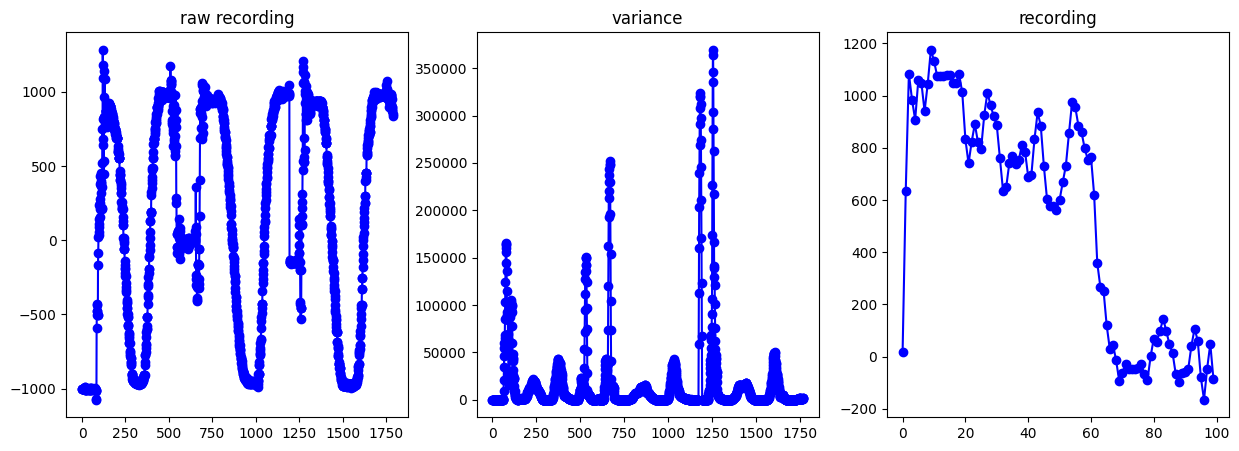

In [1386]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 

axs[0].plot(data['y1']['data'], marker='o', linestyle='-', color='b')
axs[0].set_title('raw recording')

axs[1].plot(data['y1']['var'], marker='o', linestyle='-', color='b')
axs[1].set_title('variance')

axs[2].plot(data['y1']['resampled'][2], marker='o', linestyle='-', color='b')
axs[2].set_title('recording')


Text(0.5, 1.0, 'recording')

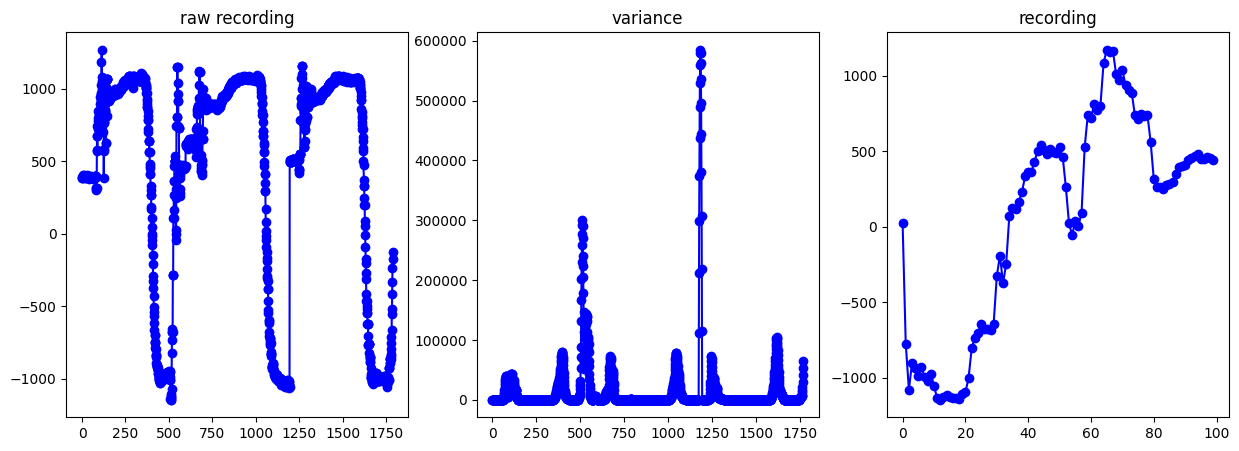

In [1384]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(data['y6']['data'], marker='o', linestyle='-', color='b')
axs[0].set_title('raw recording')

axs[1].plot(data['y6']['var'], marker='o', linestyle='-', color='b')
axs[1].set_title('variance')

axs[2].plot(data['y6']['resampled'][2], marker='o', linestyle='-', color='b')
axs[2].set_title('recording')

In [1488]:
# data['y7']['data'].append(0)

results = pd.DataFrame(
    {'y1': data['y1']['data'], 
     'y3': data['y3']['data'],
     'y5': data['y5']['data'],
     'y6': data['y6']['data'],
     'y7': data['y7']['data']}
)

results.to_csv('test_pose12.csv')

In [1484]:
len(data['y7']['data'])

221

## FINISHED

## OLD

In [1126]:
import pandas as pd
import serial
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
from scipy.signal import resample as scipy_resample
import numpy as np
import paho.mqtt.client as mqtt

mqttc = None

# Topic to publish to.
# **CHANGE THIS TO SOMETHING UNIQUE**
TOPIC = "iot/topic/yoga1"

# Create mqtt client
mqttc = mqtt.Client(callback_api_version=mqtt.CallbackAPIVersion.VERSION1)

# The callback for when the client receives a CONNACK response from the server.
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))

    # Publishing a message to a topic
    client.publish("iot/topic/yoga1", "Hello MQTT!")

def on_message(client, userdata, message):
    print("Received message '" + str(message.payload) + "' on topic '"+ message.topic + "' with QoS " + str(message.qos))

def read_serial_data(port, average_values_p1, var_window_size =20, var_threshold = 1000, resample_size = 100, baud_rate=115200, timeout=1, duration=10):
        # Create mqtt client
    global mqttc
    mqttc = mqtt.Client(callback_api_version=mqtt.CallbackAPIVersion.VERSION1)

    # Connect to broker
    mqttc.on_connect = on_connect
    mqttc.connect("broker.mqttdashboard.com")
    mqttc.on_message = on_message
    # Start the MQTT client loop
    mqttc.loop_start()
    
    mqttc.publish(topic=TOPIC, payload='Test', qos=0)
    
    readings = {}
    global ser
    
    # init_real_time_plot()  # Ensure you have initialized a Plotly FigureWidget globally
    ser = serial.Serial(port, baud_rate, timeout=timeout)
    end_time = time.time() + duration
    value_index = 0  # Cycle through 0 (x), 1 (y), 2 (z)
    sample_index = 0  # Increment for each new set of x, y, z values

    # lst_x5 = []
    # lst_y5 = []
    # lst_z5 = []
    # lst_c5 = []
    
    # lst_x6 = []
    lst_y6 = []
    # lst_z6 = []
    # lst_c6 = []
    
    # lst_x7 = []
    lst_y7 = []
    # lst_z7 = []
    # lst_c7 = []

    lst_var = []
    #lst_test = []
    test_resampled = []
    in_segment = False
    segments = []
    seg_store = []
    store = []
    timestamp = []
    
    lst_var_y6 = []
    #lst_test = []
    test_resampled_y6 = []
    in_segment_y6 = False
    segments_y6 = []
    seg_store_y6 = []
    store_y6 = []
    timestamp_y6 = []


    try:
        # while True: # if want to read data continuously
        while time.time() < end_time:  # Continuously read and plot data
            if ser.in_waiting > 0:
                data = ser.readline().decode('utf-8').strip()
                if data:
                    try:
                        value = int(data)
                        print('val', value)
                        
                        #if value_index == 0:  # X1 value                                
                        #    lst_x1.append(value)
                        #    print(value)
                            
                        if value_index == 0:  # Y5 value
                            
                            lst_y5.append(value)    
                            
                            if len(lst_y5)> var_window_size:
                                #print('inloop')
                                lst_var.append(np.var(lst_y5[len(lst_y5)-var_window_size:]))
                                print(lst_var[-1])
                                #variances = np.array([np.var(lst_y1[i:i + 10]) for i in range(len(lst_y1) - 10 + 1)])
                            if in_segment and lst_var[-1] > var_threshold:
                                #print('storing')
                                seg_store.append(lst_y5[-10])
                                # print('y5', seg_store)
                                if lst_var[-1] >100000:
                                    mqttc.publish(topic=TOPIC, payload='LEFT SHOULDERS: TOO FAST', qos=0)
          
                                               
                            if in_segment and lst_var[-1] <= var_threshold:
                                in_segment = False
                                segments.append(seg_store)
                                seg_store = []
                                test_resampled.append(scipy_resample(segments[-1], resample_size))
                                pearson_coefficient, _ = pearsonr(average_values_p1, test_resampled[-1])
                                print('PEARSON COEFFICIENT SHOULDERS:', pearson_coefficient)
                                mqttc.publish(topic=TOPIC, payload='PEARSON!!', qos=0)
                                if pearson_coefficient > 0.9:
                                    timestamp.append(len(lst_y5))
                                    print('SHOULDERS: POSE 2 DETECTED!!')
                                    mqttc.publish(topic=TOPIC, payload='SHOULDERS: POSE 2 DETECTED!!', qos=0)
                                               
                            if not in_segment and len(lst_var)>var_window_size:
                                if all(x < 2000 for x in lst_var[len(lst_var)-var_window_size:]):
                                    #print('in here', lst_var[-10:])
                                    store.append(lst_var[-1])
                                    print(lst_var[len(lst_var)-var_window_size:])
                                    if lst_var[-1] > var_threshold:
                                        #print('in here 2')
                                        seg_store.append(lst_y5[-10])
                                        in_segment = True   
                                
                        elif value_index == 1:  
                            
                            lst_y6.append(value) 
                            
                            if len(lst_y6)> var_window_size:
                                #print('inloop')
                                lst_var_y6.append(np.var(lst_y6[len(lst_y6)-var_window_size:]))
                                #variances = np.array([np.var(lst_y1[i:i + 10]) for i in range(len(lst_y1) - 10 + 1)])
                            if in_segment_y6 and lst_var_y6[-1] > var_threshold:
                                
                                seg_store_y6.append(lst_y6[-10])
                                if lst_var_y6[-1] >100000:
                                    print('SHOULDERS: TOO FAST')
                                    mqttc.publish(topic=TOPIC, payload='RIGHT SHOULDERS: TOO FAST', qos=0)
                                               
                                               
                            if in_segment_y6 and lst_var_y6[-1] <= var_threshold:
                                in_segment_y6 = False
                                segments_y6.append(seg_store_y6)
                                seg_store_y6 = []
                                test_resampled_y6.append(scipy_resample(segments_y6[-1], resample_size))
                                pearson_coefficient_y6, _ = pearsonr(average_values_p1, test_resampled_y6[-1])
                                print('PEARSON COEFFICIENT SHOULDERS:', pearson_coefficient_y6)
                                if pearson_coefficient_y6 > 0.9:
                                    print('SHOULDERS: POSE 2 DETECTED!!')
                                    mqttc.publish(topic=TOPIC, payload='SHOULDERS: POSE 2 DETECTED!!', qos=0)
                                    timestamp_y6.append(len(lst_y6))
                                               
                            if not in_segment_y6 and len(lst_var_y6)>var_window_size:
                                print(lst_var_y6)
                                if all(x < 2000 for x in lst_var_y6[len(lst_var_y6)-var_window_size:]):
                                    store_y6.append(lst_var_y6[-1])
                                    if lst_var_y6[-1] > var_threshold:
                                        #print('in here 2')
                                        seg_store_y6.append(lst_y6[-10])
                                        print('in seg', lst_var_y6[-10:])
                                        in_segment_y6 = True   
                                        
                            
                            
                                        
                        #elif value_index == 2:  
                         #   lst_z1.append(value)    
                        #elif value_index == 3:  
                         #   lst_x3.append(value)
                        #elif value_index == 4:  
                        #    lst_y3.append(value)
                        #elif value_index == 5:  
                         #   lst_z3.append(value)
                        if len(timestamp_y6) >0  and len(timestamp) >0:
                            if len(timestamp_y6) == len(timestamp) and abs(timestamp_y6[-1] - timestamp[-1]) <= 5:
                                print('SHOULDERS ARRIVED AT SAME TIME: POSE 2 ACHIEVED')
                                mqttc.publish(topic=TOPIC, payload='SHOULDERS ARRIVED AT THE SAME TIME', qos=0)
                                timestamp_y6.pop()
                                timestamp.pop()
                        #elif len(timestamp_y3) >0  and len(timestamp)==0:
                        #    print('HANDS DID NOT ARRIVE AT SAME TIME: POSE 1 NOT ACHIEVED')
                        #    timestamp_y3.pop()
                        #elif len(timestamp_y3)== 0  and len(timestamp)>0:
                        #    print('HANDS DID NOT ARRIVE AT SAME TIME: POSE 1 NOT ACHIEVED')
                        #    timestamp.pop()

                        
                        value_index = (value_index + 1) % 2  # Cycle through 0, 1, 2
                    except ValueError:
                        pass  # Ignore non-integer values

       #readings['x1'] = lst_x1
        readings['y5'] = lst_y5
        #readings['z1'] = lst_z1

        #readings['x3'] = lst_x3
        readings['y6'] = lst_y6
        #readings['z3'] = lst_z3

        readings['y5_var'] = lst_var    
        readings['y5_resampled'] = test_resampled      
        readings['y5_recorded'] = segments
        #print('last element', store)
        #print(segments)
        print(timestamp)
        print(timestamp_y6)
                                               
    finally:
        ser.close()
        mqttc.loop_stop()
        
    
    return readings


/var/folders/7q/p59p8zl57m33h1n1qpj4syr00000gn/T/ipykernel_5532/2011275195.py:18: DeprecationWarning:

Callback API version 1 is deprecated, update to latest version



In [1129]:

p1_benchmark = resample_y5[0][1]
data = read_serial_data(port, p1_benchmark, duration=20)  # Read data for 10 seconds

/var/folders/7q/p59p8zl57m33h1n1qpj4syr00000gn/T/ipykernel_5532/2011275195.py:33: DeprecationWarning:

Callback API version 1 is deprecated, update to latest version



val 332
41571.64
val -16
val 332
78733.75999999998
val -12
val 300
108945.43999999999
val -40
val 276
133374.24
val -40
val 276
153931.04
val -88
val 276
171239.36
Connected with result code 0
val -40
val 276
184406.56
val -48
val 316
195934.24000000005
val -24
val 316
202818.04
val 8
val 316
206670.84
val 108
val 500
214730.03999999998
val 168
val 536
218933.24
val 168
val 536
216187.63999999998
val 168
val 676
215656.76
val 168
val 676
206252.63999999998
val 168
val 700
191455.84000000003
val 168
val 680
164499.03999999998
val 168
val 684
129282.03999999996
val 376
val 692
83784.76
val 360
val 692
31226.039999999997
val 360
val 692
32435.640000000003
val 388
val 692
32997.240000000005
val 376
val 692
32244.6
val 364
val 692
30106.360000000008
val 364
val 692
27102.840000000004
val 404
val 712
23462.240000000005
val 384
val 712
18871.16
val 384
val 712
14669.6
val 384
val 664
9494.84
val 368
val 664
3714.5600000000004
val 368
val 676
2285.44
val 348
val 676
1290.04
val 340
val 676
196

In [1055]:
import serial
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import paho.mqtt.client as mqtt
# MQTT client object
mqttc = None

# Topic to publish to.
# **CHANGE THIS TO SOMETHING UNIQUE**
TOPIC = "iot/topic/yoga1"

global mqttc

# Create mqtt client
mqttc = mqtt.Client(callback_api_version=mqtt.CallbackAPIVersion.VERSION1)

def read_serial_data(port, average_values_p1, baud_rate=115200, timeout=1, duration=10):
    readings = {}
    global ser
    # init_real_time_plot()  # Ensure you have initialized a Plotly FigureWidget globally
    ser = serial.Serial(port, baud_rate, timeout=timeout)
    end_time = time.time() + duration
    value_index = 0  # Cycle through 0 (x), 1 (y), 2 (z)
    sample_index = 0  # Increment for each new set of x, y, z values

    lst_x5 = []
    lst_y5 = []
    lst_z5 = []
    lst_c5 = []
    
    lst_x6 = []
    lst_y6 = []
    lst_z6 = []
    lst_c6 = []
    
    lst_x7 = []
    lst_y7 = []
    lst_z7 = []
    lst_c7 = []
    
    lst_test = []
    test_resampled = []
    lst_z1 = []
    actual_signal = []


    try:
        # while True: # if want to read data continuously
        while time.time() < end_time:  # Continuously read and plot data
            if ser.in_waiting > 0:
                data = ser.readline().decode('utf-8').strip()
                if data:
                    try:
                        value = int(data)
                        if value > 900:
                            mqttc.publish(topic=TOPIC, payload='POSE 1 detected', qos=0)
                        # print(value)
                        # if value_index == 0:  # X1 value                                
                        #     lst_x1.append(value)
                        if value_index == 0:  # Y1 value
                            lst_x5.append(value)    
                            # var = rt_var.update(value)
                            # variances = np.array([np.var(lst_y1[i:i + 10]) for i in range(len(lst_y1) - 10 + 1)])
                            # if len(variances)>1:
                            #     if variances[-1] > 2000:
                            #         lst_test.append(variances[-1])
                            #         # print('var',lst_test)
                            #         # print('potential pose detected')
                            #         actual_signal.append(value)
                            #         test_resampled = [process_signal(signal, window_size) for signal in [actual_signal]]
                                    
                            #         if len(test_resampled[0]) > 0:
                            #             # print(test_resampled[0][0])
                            #             pearson_coefficient, p_value = pearsonr(average_values_p1, test_resampled[0][0])
                            #             print('pearson', pearson_coefficient)
                            #             if pearson_coefficient > 0.9:
                            #                 print('pose 1 detected')
                             
                        elif value_index == 1:  # Y1 value
                            lst_y5.append(value)           
                        elif value_index == 2:  # Y1 value
                            lst_z5.append(value)
                            
                        elif value_index == 3:  # Y1 value
                            lst_y6.append(value)
                            
                        elif value_index == 4:  # Y1 value
                            lst_y7.append(value)
                            
                        # elif value_index == 5:  # Y1 value
                        #     lst_y6.append(value)
                        # elif value_index == 6:  # Y1 value
                        #     lst_z6.append(value)
                        # elif value_index == 7:  # Y1 value
                        #     lst_c6.append(value)
                        # elif value_index == 8:  # Y1 value
                        #     lst_x7.append(value)
                        # elif value_index == 9:  # Y1 value
                        #     lst_y7.append(value)
                            
                        # elif value_index == 10:  # Y1 value
                        #     lst_z7.append(value)
                        # elif value_index == 11:  # Y1 value
                        #     lst_c7.append(value)

                            # sample_index += 1  # Increment sample_index after a full cycle
                        
                        value_index = (value_index + 1) % 5  # Cycle through 0, 1, 2
                    except ValueError:
                        pass  # Ignore non-integer values
                # time.sleep(0.05)  # Adjust based on your data rate
                # if len(lst_y1)>0 and len(lst_y3)>0:
                #     if lst_y1[-1] <-900 and lst_y3[-1]<-960:
                #         send_alert_to_microbit(ser, "Alertttt")
        readings['x5'] = lst_x5
        readings['y5'] = lst_y5
        readings['z5'] = lst_z5        
        # readings['c5'] = lst_c5
        # readings['x6'] = lst_x6
        readings['y6'] = lst_y6
        # readings['z6'] = lst_z6        
        # readings['c6'] = lst_c6
        # readings['x7'] = lst_x7
        readings['y7'] = lst_y7
        # readings['z7'] = lst_z7        
        # readings['c7'] = lst_c7
        # readings['z3'] = lst_z3
        # readings['r3'] = lst_r3
        # readings['p3'] = lst_p3   
        # readings['y1_var'] = lst_test    
        # readings['y1_resampled'] = test_resampled[0]      
        # readings['y1_actual_signal'] = actual_signal
    finally:
        ser.close()
        
    

    
    
    return readings


/var/folders/7q/p59p8zl57m33h1n1qpj4syr00000gn/T/ipykernel_5532/2814234120.py:16: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  mqttc = mqtt.Client(callback_api_version=mqtt.CallbackAPIVersion.VERSION1)


In [1058]:
port = '/dev/tty.usbmodem21202'  # Example for Linux/Mac. Use 'COM#' for Windows.
data = read_serial_data(port, resample_y5[0][1], duration=20)  # Read data for 10 seconds



In [1059]:
data

{'x5': [1016,
  564,
  892,
  1012,
  608,
  872,
  992,
  596,
  900,
  1004,
  616,
  960,
  1020,
  720,
  968,
  988,
  836,
  1012,
  984,
  832,
  1052,
  992,
  860,
  1044,
  980,
  828,
  1036,
  980,
  852,
  1032,
  988,
  888,
  1024,
  992,
  872,
  1040,
  992,
  848,
  1044,
  988,
  888,
  1064,
  988,
  884,
  1060,
  984,
  868,
  1072,
  996,
  852,
  1056,
  984,
  868,
  1056,
  996,
  872,
  1060,
  996,
  872,
  1044,
  992,
  864,
  1052,
  980,
  872,
  1060,
  996,
  860,
  1060,
  980,
  872,
  1056,
  1000,
  876,
  1052,
  1000,
  856,
  1056,
  1004,
  860,
  1008,
  1012,
  804,
  932,
  1028,
  700,
  972,
  1012,
  484,
  900,
  1016,
  460,
  788,
  996,
  300,
  720,
  964,
  204,
  556,
  916,
  76,
  464,
  872,
  -8,
  376,
  812,
  -116,
  276,
  776,
  -164,
  160,
  708,
  -280,
  108,
  656,
  -348,
  -4,
  584,
  -444,
  -164,
  508,
  -480,
  -204,
  500,
  -492,
  -244,
  464,
  -504,
  -280,
  408,
  -516,
  -324,
  348,
  -520,
  -360,
  3

## For exporting of sensor readings

In [1060]:
import pandas as pd
df = pd.DataFrame({k : pd.Series(v) for k, v in data.items()})

df.to_csv('pose2_test2.csv')

## Reading sensor data

In [1061]:
import pandas as pd
data = pd.read_csv('pose2_test2.csv')

test_x5 = data['x5'].tolist()
test_y5 = data['y5'].tolist()
test_z5 = data['z5'].tolist()
# test_c5 = data['c5'].tolist()
# test_x6 = data['x6'].tolist()
test_y6 = data['y6'].tolist()
# test_z6 = data['z6'].tolist()
# test_c6 = data['c6'].tolist()
# test_x7 = data['x7'].tolist()
test_y7 = data['y7'].tolist()
# test_z7 = data['z7'].tolist()
# test_c7 = data['c7'].tolist()


In [1045]:
data

,Unnamed: 0,x5,y5,z5,y6,y7,rolling_var_x5_10,rolling_var_y5_10,rolling_var_z5_10,rolling_var_y6_10,rolling_var_y7_10,rolling_var_x5_20,rolling_var_y5_20,rolling_var_z5_20,rolling_var_y6_20,rolling_var_y7_20
0,0,1004,924,708,1000,920.0,444.60,125091.96,229187.64,575094.20,445615.20,444.60,125091.96,229187.64,575094.20,445615.20
1,1,708,1004,924,708,1012.0,454.56,108016.44,199917.56,507495.20,384622.20,454.56,108016.44,199917.56,507495.20,384622.20
2,2,928,692,1004,924,700.0,487.16,83495.80,160738.04,407472.96,297590.20,487.16,83495.80,160738.04,407472.96,297590.20
3,3,1012,928,712,1008,916.0,510.84,55173.24,118012.60,289681.44,202469.56,510.84,55173.24,118012.60,289681.44,202469.56
4,4,704,1008,912,696,1004.0,578.04,28387.84,66221.56,156907.04,108035.64,578.04,28387.84,66221.56,156907.04,108035.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,239,-728,-788,-128,-744,-788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,240,-140,-720,-780,-136,-732.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,241,-784,-144,-744,-792,-136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,242,-740,-792,-136,-732,-788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1062]:
# Variance
import statistics

def rolling_variance(values, window_size=20):
    variances = []  # List to store the variances of each window
    for i in range(len(values) - window_size + 1):
        window = values[i:i+window_size]  # Extract the window
        var = np.var(window)  # Compute variance of the window
        variances.append(var)  # Append the variance to the list
    return variances

data['rolling_var_x5_10'] = rolling_variance(test_x5, window_size=10) + [None] * (len(data['x5']) - len(rolling_variance(test_x5, window_size=10)))
data['rolling_var_y5_10'] = rolling_variance(test_y5, window_size=10) + [None] * (len(data['y5']) - len(rolling_variance(test_y5, window_size=10)))
data['rolling_var_z5_10'] = rolling_variance(test_z5, window_size=10) + [None] * (len(data['z5']) - len(rolling_variance(test_z5, window_size=10)))
# data['rolling_var_c5_10'] = rolling_variance(test_c5) + [None] * (len(data['c5']) - len(rolling_variance(test_c5)))
# data['rolling_var_x6_10'] = rolling_variance(test_x6) + [None] * (len(data['x6']) - len(rolling_variance(test_x6)))
data['rolling_var_y6_10'] = rolling_variance(test_y6, window_size=10) + [None] * (len(data['y6']) - len(rolling_variance(test_y6, window_size=10)))
# data['rolling_var_z6_10'] = rolling_variance(test_z6) + [None] * (len(data['z6']) - len(rolling_variance(test_z6)))
# data['rolling_var_c6_10'] = rolling_variance(test_c6) + [None] * (len(data['c6']) - len(rolling_variance(test_c6)))
# data['rolling_var_x7_10'] = rolling_variance(test_x7) + [None] * (len(data['x7']) - len(rolling_variance(test_x7)))
data['rolling_var_y7_10'] = rolling_variance(test_y7, window_size=10) + [None] * (len(data['y7']) - len(rolling_variance(test_y7, window_size=10)))
# data['rolling_var_z7_10'] = rolling_variance(test_z7) + [None] * (len(data['z7']) - len(rolling_variance(test_z7)))
# data['rolling_var_c7_10'] = rolling_variance(test_c7) + [None] * (len(data['c7']) - len(rolling_variance(test_c7)))

data['rolling_var_x5_20'] = rolling_variance(test_x5, window_size=20) + [None] * (len(data['x5']) - len(rolling_variance(test_x5)))
data['rolling_var_y5_20'] = rolling_variance(test_y5, window_size=20) + [None] * (len(data['y5']) - len(rolling_variance(test_y5)))
data['rolling_var_z5_20'] = rolling_variance(test_z5, window_size=20) + [None] * (len(data['z5']) - len(rolling_variance(test_z5)))
# data['rolling_var_c5_20'] = rolling_variance(test_c5) + [None] * (len(data['c5']) - len(rolling_variance(test_c5)))
# data['rolling_var_x6_20'] = rolling_variance(test_x6) + [None] * (len(data['x6']) - len(rolling_variance(test_x6)))
data['rolling_var_y6_20'] = rolling_variance(test_y6, window_size=20) + [None] * (len(data['y6']) - len(rolling_variance(test_y6)))
# data['rolling_var_z6_20'] = rolling_variance(test_z6) + [None] * (len(data['z6']) - len(rolling_variance(test_z6)))
# data['rolling_var_c6_20'] = rolling_variance(test_c6) + [None] * (len(data['c6']) - len(rolling_variance(test_c6)))
# data['rolling_var_x7_20'] = rolling_variance(test_x7) + [None] * (len(data['x7']) - len(rolling_variance(test_x7)))
data['rolling_var_y7_20'] = rolling_variance(test_y7, window_size=20) + [None] * (len(data['y7']) - len(rolling_variance(test_y7)))
# data['rolling_var_z7_20'] = rolling_variance(test_z7) + [None] * (len(data['z7']) - len(rolling_variance(test_z7)))
# data['rolling_var_c7_20'] = rolling_variance(test_c7) + [None] * (len(data['c7']) - len(rolling_variance(test_c7)))




In [1063]:
# df = pd.DataFrame(data)
data.to_csv('pose2_test2.csv', index=False)

In [368]:
import numpy as np
from scipy.signal import resample
import numpy as np
from sklearn.utils import resample as sklearn_resample

def compute_variance_windows(signal, window_size):
    """
    Computes variance for sliding windows across a signal.

    :param signal: 1D numpy array of signal values.
    :param window_size: The number of samples in each window.
    :return: 1D numpy array of variances for each window.
    """
    variances = np.array([np.var(signal[i:i + window_size]) for i in range(len(signal) - window_size + 1)])
    return variances

def find_all_action_segments(variances, threshold=1500):
    """
    Identifies all action segments based on variance changes.
    
    :param variances: 1D numpy array of variances for each window.
    :param threshold: Threshold for considering a variance as indicating action.
    :return: A list of tuples, each tuple containing (start_index, end_index) of an action segment.
    """
    segments = []
    in_segment = False
    for i, v in enumerate(variances):
        if v > threshold and not in_segment:
            start_index = i
            in_segment = True
        elif v <= threshold and in_segment:
            end_index = i
            segments.append((start_index, end_index))
            in_segment = False
    if in_segment:  # If still in an action by the end of the array
        segments.append((start_index, len(variances)))
    return segments

def process_signal(signal, window_size, resample_size=100):
    """
    Processes a signal to find all actions, extract them, and resample them.
    
    :param signal: 1D numpy array of signal values.
    :param window_size: The number of samples in each window for variance computation.
    :param resample_size: The number of points to resample each extracted action to.
    :return: A list of 1D numpy arrays, each representing a resampled action segment.
    """
    variances = compute_variance_windows(signal, window_size)
    action_segments = find_all_action_segments(variances)
    
    resampled_actions = []
    for start_index, end_index in action_segments:
        print(start_index, end_index)
        # Extract the action
        action_signal = signal[start_index:end_index]
        # Resample the action
        resampled_action = resample(action_signal, resample_size)
        resampled_actions.append(resampled_action)
    
    # Combine all resampled actions into a single dataset
    resampled_dataset = np.vstack(resampled_actions)
    
    return resampled_dataset


In [785]:
test2_2 = pd.read_csv('pose2_2.csv')
test2_3 = pd.read_csv('pose2_3.csv')
test2_4 = pd.read_csv('pose2_4.csv')
test2_5 = pd.read_csv('pose2_5.csv')

# lst = [test_y5,test_y6,test_y7]
lst_y5 = [test2_2['y5'].tolist(),test2_3['y5'].tolist(),test2_4['y5'].tolist(),test2_5['y5'].tolist()]
lst_y6 = [test2_2['y6'].tolist(),test2_3['y6'].tolist(),test2_4['y6'].tolist(),test2_5['y6'].tolist()]
lst_y7 = [test2_2['y7'].tolist(),test2_3['y7'].tolist(),test2_4['y7'].tolist(),test2_5['y7'].tolist()]


# test_x1 = pd.read_csv('test16.csv')['y1'].tolist()
# test_resampled = [process_signal(signal, window_size) for signal in [test_x1]]


# var = [compute_variance_windows(signal, window_size) for signal in [train_x1, train_x2, train_x3, train_x4]]


resample_y5= [process_signal(signal, window_size) for signal in [test2_5['y5'].tolist()]]
# df = pd.DataFrame(resample)

# df.T.to_csv('testt.csv')

0 6
60 112


In [ ]:
data = np.array([resample[0][1], resample[1][1], resample[2][1], resample[3][1]])

# Compute the average across the first dimension (i.e., across your lists)
average_values_p1 = np.mean(data, axis=0)

In [559]:

data = np.array([resample[0][1], resample[1][1], resample[2][1], resample[3][1]])

# Compute the average across the first dimension (i.e., across your lists)
average_values_p1 = np.mean(data, axis=0)


In [562]:
average_values_p1

array([638.        , 727.46119547, 670.46194019, 616.7639528 ,
       628.69483643, 653.02120229, 645.16319022, 622.90309786,
       610.86487989, 607.13476908, 605.84021606, 605.33863901,
       597.68929109, 581.00440276, 570.00425558, 571.63210145,
       570.16647745, 556.03813614, 544.43193753, 546.38501507,
       548.23736207, 538.35092712, 527.79314887, 526.95163571,
       526.6681043 , 518.51688714, 510.69312576, 509.96119395,
       508.73754925, 501.22655903, 493.45861896, 489.03923193,
       482.303486  , 471.39903506, 462.36467937, 456.79010748,
       449.7317902 , 440.97035862, 434.94224665, 430.00345549,
       420.38337523, 407.69900477, 399.4286882 , 397.49141314,
       397.30099047, 395.65066892, 392.41977523, 387.83300699,
       383.16365494, 379.54774061, 373.02952727, 358.0838926 ,
       339.0418636 , 328.19989525, 327.65609399, 323.84796104,
       307.94479338, 291.33821514, 289.43453464, 297.58616812,
       297.37467382, 283.61226323, 269.64804126, 264.43

In [475]:
df = pd.DataFrame(test_resampled[0][1]).transpose()  # Transpose to switch rows to columns

# Export to CSV
df.to_csv('resample.csv', index=False)

In [305]:
df = pd.DataFrame({'y1_adjusted': pd.Series(adjusted_values), 'y1_var': pd.Series(var[0]), 'y1_resampled':pd.Series(resample(flattened_list, 100))})
df.to_csv('test11_r.csv')

In [310]:
import numpy as np


values = pd.read_csv('test13.csv')['y1'].tolist()
# Calculate a simple moving average (SMA) with a window size of 3 as an example
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'same') / window_size

# Calculate SMA for each data point
smoothed_values = moving_average(values, 10)

# Define a threshold for detecting outliers based on deviation from the smoothed values
threshold = 30  # This value may need adjustment based on your specific case

# Identify outliers
outliers = np.abs(values - smoothed_values) > threshold

# Adjust outliers by setting them to the moving average of their neighbors
adjusted_values_5 = np.copy(values)
adjusted_values_5[outliers] = smoothed_values[outliers]

# adjusted_values now contains the values where outliers have been adjusted


In [545]:
from scipy.stats import pearsonr

def compare_test_train_similarity(test_data, train_data):
    """
    Computes the Pearson correlation coefficient between test data instances and each training data instance.

    :param test_data: List of numpy arrays (test instances).
    :param train_data: List of numpy arrays (training instances).
    :return: A list of lists containing Pearson correlation coefficients.
    """
    similarities = []
    for test_instance in test_data:
        instance_similarities = []
        for train_instance in train_data:
            if len(test_instance) == len(train_instance):  # Ensure comparability
                correlation, _ = pearsonr(test_instance, train_instance)
                instance_similarities.append(correlation)
            else:
                instance_similarities.append(None)  # Handle unequal lengths
        similarities.append(instance_similarities)
    return similarities

# Assuming resampled_actions_train and resampled_actions_test are your processed datasets
similarity_scores = compare_test_train_similarity(test_resampled, train_resampled)

# Now, similarity_scores contains the Pearson correlation for each test instance against each training instance


In [644]:
similarity_scores = compare_test_train_similarity(test_resampled, resample)

TypeError: object of type 'numpy.float64' has no len()

In [646]:
p, pval = pearsonr(test_resampled[0][1], average_values_p1)

In [647]:
p

0.9863948438087962

In [547]:
similarity_scores

[[None, None, None, None]]

## For plotting of readings

In [56]:
import serial
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def read_serial_data(port, baud_rate=115200, timeout=1, duration=10):
    
    global ser
    init_real_time_plot()  # Ensure you have initialized a Plotly FigureWidget globally
    ser = serial.Serial(port, baud_rate, timeout=timeout)
    end_time = time.time() + duration
    value_index = 0  # Cycle through 0 (x), 1 (y), 2 (z)
    sample_index = 0  # Increment for each new set of x, y, z values

    lst_y1 = []
    lst_y3 = []
    try:
        while True: # if want to read data continuously
        # while time.time() < end_time:  # Continuously read and plot data
            if ser.in_waiting > 0:
                data = ser.readline().decode('utf-8').strip()
                if data:
                    try:
                        value = int(data)
                        # print(data,value)
                        # Determine which plot to update based on value_index
                        # if value_index == 0:  # X value
                        #     add_data_to_plot(ser, value, None, None, sample_index)
                        # elif value_index == 1:  # Y value
                        #     add_data_to_plot(ser, None, value, None, sample_index)
                        
                        if value_index == 0:  # X value                                
                            add_data_to_plot(ser, None, value, None, sample_index)
                            lst_y1.append(value)
                        elif value_index == 1:  # Y value
                            add_data_to_plot(ser, None, None, value, sample_index)
                            lst_y3.append(value)
                        # elif value_index == 2:  # Z value
                        #     add_data_to_plot(ser, None, None, value, sample_index)
                            sample_index += 1  # Increment sample_index after a full cycle
                        
                        value_index = (value_index + 1) % 2  # Cycle through 0, 1, 2
                    except ValueError:
                        pass  # Ignore non-integer values
                # time.sleep(0.01)  # Adjust based on your data rate
                if len(lst_y1)>1 and len(lst_y3)>1:
                    if lst_y1[-1] <-900 and lst_y1[-2]>-900 and any(value < -900 for value in lst_y3[-50:]):
                        print('alerted', lst_y1[-10:], lst_y3[-50:])
                        send_alert_to_microbit(ser, "Alertttt")
                if len(lst_y1) > 100: 
                    del lst_y1[:50]
                if len(lst_y3) > 100:
                    del lst_y3[:50]
                
                if len(lst_y1) >= 10:
                    dynamic_list = lst_y1[-10:]
                    gradient = (dynamic_list[-1] - dynamic_list[0])/10
                    # print('dynamic list', dynamic_list, gradient)
                    if gradient < -95:
                        print('NO')
                        send_alert_to_microbit(ser, "Too fast!")
                    if gradient < -20 and gradient >= -95:
                        print('yes')
                        send_alert_to_microbit(ser, "The speed is good")
                
    finally:
        ser.close()


In [1070]:
# Define window size for the moving average
N = 20 # Example window size
# Initialize rolling windows for x, y, z values
rolling_window_y1, rolling_window_y3, rolling_window_y5, rolling_window_y6, rolling_window_y7 = [], [], [], [], []

# THRESHOLD_X = -150
# THRESHOLD_Y = -960
# THRESHOLD_Z = -900
# data = {
#     'x': [],
#     'y': [],
#     'z': [],
#     'x_moving_avg': [],
#     'y_moving_avg': [],
#     'z_moving_avg': []
# }

def add_data_to_plot(serial_connection, y1, y3, y5, y6, y7, sample_index):
    resp = ''
    # global rolling_window_x, rolling_window_y, rolling_window_z
    global rolling_window_y1, rolling_window_y3, rolling_window_y5, rolling_window_y6, rolling_window_y7 

    
    # Update and calculate moving average for X values, check threshold
    # if x_new is not None:
    #     rolling_window_x.append(x_new)
    #     rolling_window_x = rolling_window_x[-N:]
    #     x_moving_avg = sum(rolling_window_x) / len(rolling_window_x)
        
        
        
    #     with fig_x.batch_update():
    #         fig_x.data[0].x += (sample_index,)
    #         fig_x.data[0].y += (x_new,)
    #         fig_x.data[1].x += (sample_index,)
    #         fig_x.data[1].y += (x_moving_avg,)
        
    #     if x_moving_avg > THRESHOLD_X:
    #         # print('alertx')
    #         send_alert_to_microbit(serial_connection, "Alert X")

    # Repeat the process for Y and Z values
    if y1 is not None:
        # rolling_window_y.append(y_new)
        # rolling_window_y = rolling_window_y[-N:]
        # y_moving_avg = sum(rolling_window_y) / len(rolling_window_y)
        
        with fig_y1.batch_update():
            fig_y1.data[0].x += (sample_index,)
            fig_y1.data[0].y += (y1,)
            # fig_y.data[1].x += (sample_index,)
            # fig_y.data[1].y += (y_moving_avg,)
            # Ensure only the last 100 data points are retained
            fig_y1.data[0].x = fig_y1.data[0].x[-100:]  # Keep last 100 x values
            fig_y1.data[0].y = fig_y1.data[0].y[-100:]  # Keep last 100 y values
            
        # if rolling_window_y[-1] < THRESHOLD_Y:
            
        # if y_new < THRESHOLD_Y:
        #     # print('alerty')
        #     send_alert_to_microbit(serial_connection, "Alert Y")
            
    if y3 is not None:
        # rolling_window_z.append(z_new)
        # rolling_window_z = rolling_window_z[-N:]
        # z_moving_avg = sum(rolling_window_z) / len(rolling_window_z)
        # z_moving_avg = sum(rolling_window_z) / len(rolling_window_z)
        
        with fig_y3.batch_update():
            fig_y3.data[0].x += (sample_index,)
            fig_y3.data[0].y += (y3,)
            # fig_y1.data[1].x += (sample_index,)
            # fig_z.data[1].y += (z_moving_avg,)
            # Ensure only the last 100 data points are retained
            fig_y3.data[0].x = fig_y3.data[0].x[-100:]  # Keep last 100 x values
            fig_y3.data[0].y = fig_y3.data[0].y[-100:]  # Keep last 100 y values
        
        
        # if z_new < THRESHOLD_Z:
        #     # print('alertz')
        #     send_alert_to_microbit(serial_connection, "Alert Z")

    if y5 is not None:
        # rolling_window_z.append(z_new)
        # rolling_window_z = rolling_window_z[-N:]
        # z_moving_avg = sum(rolling_window_z) / len(rolling_window_z)
        # z_moving_avg = sum(rolling_window_z) / len(rolling_window_z)
        
        with fig_y5.batch_update():
            fig_y5.data[0].x += (sample_index,)
            fig_y5.data[0].y += (y5,)
            # fig_y1.data[1].x += (sample_index,)
            # fig_z.data[1].y += (z_moving_avg,)
            # Ensure only the last 100 data points are retained
            fig_y5.data[0].x = fig_y5.data[0].x[-100:]  # Keep last 100 x values
            fig_y5.data[0].y = fig_y5.data[0].y[-100:]  # Keep last 100 y values
            
            
    if y6 is not None:
        # rolling_window_z.append(z_new)
        # rolling_window_z = rolling_window_z[-N:]
        # z_moving_avg = sum(rolling_window_z) / len(rolling_window_z)
        # z_moving_avg = sum(rolling_window_z) / len(rolling_window_z)
        
        with fig_y6.batch_update():
            fig_y6.data[0].x += (sample_index,)
            fig_y6.data[0].y += (y6,)
            # fig_y1.data[1].x += (sample_index,)
            # fig_z.data[1].y += (z_moving_avg,)
            # Ensure only the last 100 data points are retained
            fig_y6.data[0].x = fig_y6.data[0].x[-100:]  # Keep last 100 x values
            fig_y6.data[0].y = fig_y6.data[0].y[-100:]  # Keep last 100 y values
            
    if y7 is not None:
        # rolling_window_z.append(z_new)
        # rolling_window_z = rolling_window_z[-N:]
        # z_moving_avg = sum(rolling_window_z) / len(rolling_window_z)
        # z_moving_avg = sum(rolling_window_z) / len(rolling_window_z)
        
        with fig_y7.batch_update():
            fig_y7.data[0].x += (sample_index,)
            fig_y7.data[0].y += (y7,)
            # fig_y1.data[1].x += (sample_index,)
            # fig_z.data[1].y += (z_moving_avg,)
            # Ensure only the last 100 data points are retained
            fig_y7.data[0].x = fig_y7.data[0].x[-100:]  # Keep last 100 x values
            fig_y7.data[0].y = fig_y7.data[0].y[-100:]  # Keep last 100 y values
    #if rolling_window_y[-1] < THRESHOLD_Y and sum(rolling_window_y[-10:])/10 > -800 and sum(rolling_window_z[-10:])/10 < THRESHOLD_Z:
    #    print('test')
    #    send_alert_to_microbit(ser, "Alertttt")
    # print(rolling_window_y)
    # if rolling_window_y[-1] < THRESHOLD_Y:
    # # if rolling_window_y[-1] < THRESHOLD_Y and sum(rolling_window_y[-10:])/10 > -300:
    #     print('last 10', rolling_window_y[-10:])
    #     send_alert_to_microbit(serial_connection, "Alertttt")

In [4]:
port = '/dev/tty.usbmodem21102'  # Example for Linux/Mac. Use 'COM#' for Windows.
read_serial_data(port, duration=15)  # Read data for 10 seconds


FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Y Values',
              'type': 'scatter',
              'uid': '68a4250f-4c70-4156-8452-3fcdb38a65a0',
              'x': [],
              'y': []},
             {'line': {'color': 'red'},
              'mode': 'lines',
              'name': 'Y Moving Avg',
              'type': 'scatter',
              'uid': '2a2e8f25-aca0-41ad-b03c-08438eafd83f',
              'x': [],
              'y': []}],
    'layout': {'template': '...', 'title': {'text': 'Real-Time Y1 Values'}}
})

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Z Values',
              'type': 'scatter',
              'uid': '750d8fb0-c83c-4199-b498-667947ba0ce0',
              'x': [],
              'y': []},
             {'line': {'color': 'red'},
              'mode': 'lines',
              'name': 'Z Moving Avg',
              'type': 'scatter',
              'uid': 'e826ee4a-5b32-4607-8872-97863347da94',
              'x': [],
              'y': []}],
    'layout': {'template': '...', 'title': {'text': 'Real-Time Y3 Values'}}
})

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
-960220 -960220
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
-972220 -972220
0 0
-972220 -972220
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


KeyboardInterrupt: 